In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import copy

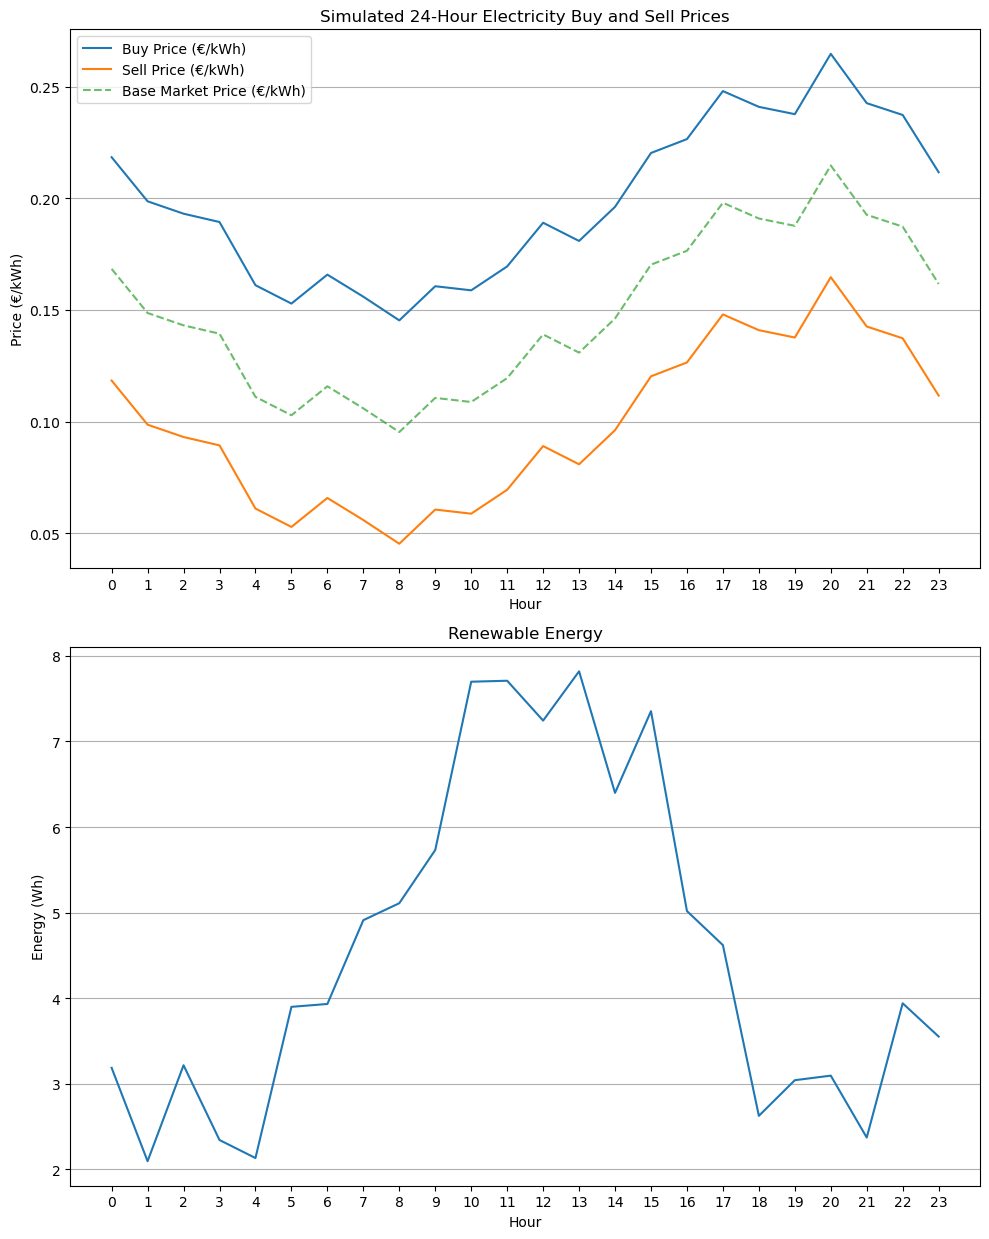

In [47]:
# Set seed for reproducibility
np.random.seed(42)

# === 1. Time Horizon ===
H = 24
horizon = 6
N = 5
M = 1

hours = np.arange(H)
base_price = 0.15
amplitude = 0.10

q = np.zeros((M,H))


# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 12.5))  # 1 row, 2 columns



noise = np.random.normal(0, 0.01, size=H)
# Symmetric price
prices = base_price + amplitude * (
    np.sin((hours - 8) / 24 * 2 * np.pi) + np.sin((hours - 18) / 24 * 2 * np.pi)
) + noise
prices = np.clip(prices, 0.05, None)
    
# Add asymmetric buy/sell prices
margin = 0.05
c = prices + margin
p = prices - margin
p = np.clip(p, 0.01, None)  # Prevent negative prices

# First subplot: Buy and Sell Prices
axs[0].plot(hours, c, label='Buy Price (€/kWh)')
axs[0].plot(hours, p, label='Sell Price (€/kWh)')
axs[0].plot(hours, prices, label='Base Market Price (€/kWh)', linestyle='--', alpha=0.7)
axs[0].set_title("Simulated 24-Hour Electricity Buy and Sell Prices")
axs[0].set_xlabel("Hour")
axs[0].set_ylabel("Price (€/kWh)")
axs[0].grid(axis='y')
axs[0].set_xticks(range(0, 24))
axs[0].legend()

for m in range(M):    
    # === 3. Generate Renewable Energy ===
    pv_gen = np.maximum(0, 5 * np.sin((hours - 6) * np.pi / 12))  # PV peaks at noon
    wt_gen = 2 + np.random.rand(H) * 2  # Wind is random but consistent
    q[m] = (pv_gen + wt_gen)
    # Second subplot: Renewable energy
    axs[1].plot(np.arange(H), q[m])
    axs[1].set_title("Renewable Energy")
    axs[1].set_xlabel("Hour")
    axs[1].set_ylabel("Energy (Wh)")
    axs[1].grid(axis='y')
    axs[1].set_xticks(range(0, 24))

plt.tight_layout()
plt.savefig("Environmental parameters", dpi=300)
plt.show()

In [49]:
# Parameters
c1 = 5
c2 = 1
np.random.seed(42)
L_target = np.random.uniform(70, 90, size=(M,N))
L_init = np.random.uniform(20, 60, size=(M,N))

d_min = np.zeros((M, H))
d_max = np.ones((M, H)) * 10

f_min = np.zeros((M, H))
f_max = np.ones((M, H)) * 10

# Decision variables for each agent
x = [cp.Variable(2*H) for _ in range(M)]

constraints = []
objective = 0
cost_terms = []
target_terms = []

for m in range(M):
    d = x[m][:H]
    f = x[m][H:2*H]

    constraints += [
        d >= d_min[m],
        d <= d_max[m],
        f >= f_min[m],
        f <= f_max[m]
    ]

    for h in range(1, H):
        constraints += [
            cp.abs(f[h-1] - f[h]) <= 1,
            cp.abs(d[h-1] - d[h]) <= 1
        ]

    energy_cost = cp.sum(cp.multiply(c, d) / q[m] - cp.multiply(p, f) / q[m])
    expected_load = cp.sum(L_target[m,:] - L_init[m,:])
    remaining_energy = cp.sum(q[m] + d - f)
    energy_target =  cp.sum_squares(expected_load - remaining_energy)
    objective += c1 * energy_cost + c2 *energy_target
    cost_terms.append(energy_cost)
    target_terms.append(energy_target)

# Solve the problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve(solver="CLARABEL")


# Collect data for plotting
d_history = np.array([x[m][:H].value for n in range(M)])
f_history = np.array([x[m][H:2*H].value for n in range(M)])

for m in range(M):
    print(f"Objective functions in Agent {m}: "
          f"Cost term: {cost_terms[m].value:.2f}, "
          f"Target term: {target_terms[m].value:.2f}, "
          f"overall objective: {cost_terms[m].value + target_terms[m].value:.2f}")

Objective functions in Agent 0: Cost term: 3.67, Target term: 0.02, overall objective: 3.68


In [82]:
rho = 1.8 #1.8
gamma = 0.01


epsilon = 0.1
c1 = 5
eta = 0.9

# Parameters
L_min = np.ones((M, N, H)) * 20
L_max = np.ones((M, N, H)) * 100

l_min = np.zeros((M, N, H))
l_max = np.ones((M, N, H)) * 10

r_min = np.zeros((M, N, H))
r_max = np.ones((M, N, H)) * 10

# Decision variables for each agent
x = [[cp.Variable(3*H) for _ in range(N)] for _ in range(M)]

energy_terms = []
penalty_terms = []

# Initial values
x = np.array([[np.zeros(3*H) for _ in range(N)] for _ in range(M)])  # d, f, l, m, L[1:]
lambdas = np.zeros((M,H))

x_prev = copy.deepcopy(x)
iteration = 0

E = q + d_history - f_history


# Collect data for plotting
l_history = np.array([[np.zeros(H) for n in range(N)]for _ in range(M)])
r_history = np.array([[np.zeros(H) for n in range(N)]for _ in range(M)])
L_history = np.array([[np.zeros(H) for n in range(N)]for _ in range(M)])

H_n_T_x = np.zeros((M,N,H))
H_n_T_xi = np.zeros((M,N,H))

while True:
    iteration+=1
    for m in range(M):
        for n in range(N):
            constraints = []
            xi = cp.Variable(3*H)
            l = xi[:H]
            r = xi[H:2*H]
            L = xi[2*H:3*H]
            
            constraints += [
                L >= L_min[m][n],
                L <= L_max[m][n],
                l >= l_min[m][n],
                l <= l_max[m][n],
                r >= r_min[m][n],
                r <= r_max[m][n]
            ]
        
            constraints += [
                L[0] == L_init[m][n]
            ]
            
            for h in range(1, H):
                constraints += [
                    L[h] == L[h-1] + l[h] - r[h]
                    #cp.abs(l[h-1] - l[h]) <= 1,
                    #cp.abs(r[h-1] - r[h]) <= 1
                ]
            
            penalty_term = cp.sum_squares(L[-1]-L_target[m][n])
            h_n_T_x = l - r
            H_n_T_prev = cp.sum(H_n_T_x[m],axis=0) - H_n_T_x[m][n] - E[m]
            admm_penalty = (rho/2) * cp.sum_squares(h_n_T_x  + H_n_T_prev - 1/rho * lambdas[m])
            admm_update = (9/2) * cp.sum_squares(xi - x_prev[m][n])
    
            objective = cp.Minimize(penalty_term + admm_penalty + admm_update)
            prob = cp.Problem(objective, constraints)
            prob.solve(solver="CLARABEL")
    
            # Save values
            x[m][n] = copy.deepcopy(xi.value)
            H_n_T_xi[m][n] = copy.deepcopy(h_n_T_x.value)
    
            # Collect data for plotting
            l_history[m][n] = copy.deepcopy(l.value)
            r_history[m][n] = copy.deepcopy(r.value)
            L_history[m][n] = copy.deepcopy(L.value)

            """
            print(f"######### Parameters for Agent: {n} ##########")
            print(f"Net cost: {penalty_term.value}")
            print(f"Lambda penalty: {admm_penalty.value}")
            print(f"Update penalty: {admm_update.value}")
            #print(f"Objective value: {objective.value}")
            print(f"############################################")
            print(f" ")
            #"""
    
    H_n_T_x = copy.deepcopy(H_n_T_xi)
    
    lambdas -= gamma * rho * (np.sum(H_n_T_x, axis=1) - E)
    #gamma *=0.9
    print("--------------------------------------------")
    print(f"ITERATION: {iteration}, difference: {np.linalg.norm(x-x_prev)}")
    
    print(f"lambda {np.linalg.norm(np.sum(H_n_T_x,axis=1) - E)}")
    print("--------------------------------------------")
    print(f" ")

    if np.linalg.norm(x-x_prev) <= epsilon and np.linalg.norm(np.sum(H_n_T_x,axis=1) - E) < 0.8:
            break
        
    x_prev = copy.deepcopy(x)


--------------------------------------------
ITERATION: 1, difference: 245.58179127758262
lambda 78.23440778452273
--------------------------------------------
 
--------------------------------------------
ITERATION: 2, difference: 22.457466338105142
lambda 77.13587114317504
--------------------------------------------
 
--------------------------------------------
ITERATION: 3, difference: 16.087776276668567
lambda 78.70237447083005
--------------------------------------------
 
--------------------------------------------
ITERATION: 4, difference: 13.058664050756835
lambda 79.74476845482182
--------------------------------------------
 
--------------------------------------------
ITERATION: 5, difference: 11.335745052302839
lambda 80.11740773892704
--------------------------------------------
 
--------------------------------------------
ITERATION: 6, difference: 10.207160414440384
lambda 80.01089502538176
--------------------------------------------
 
----------------------------

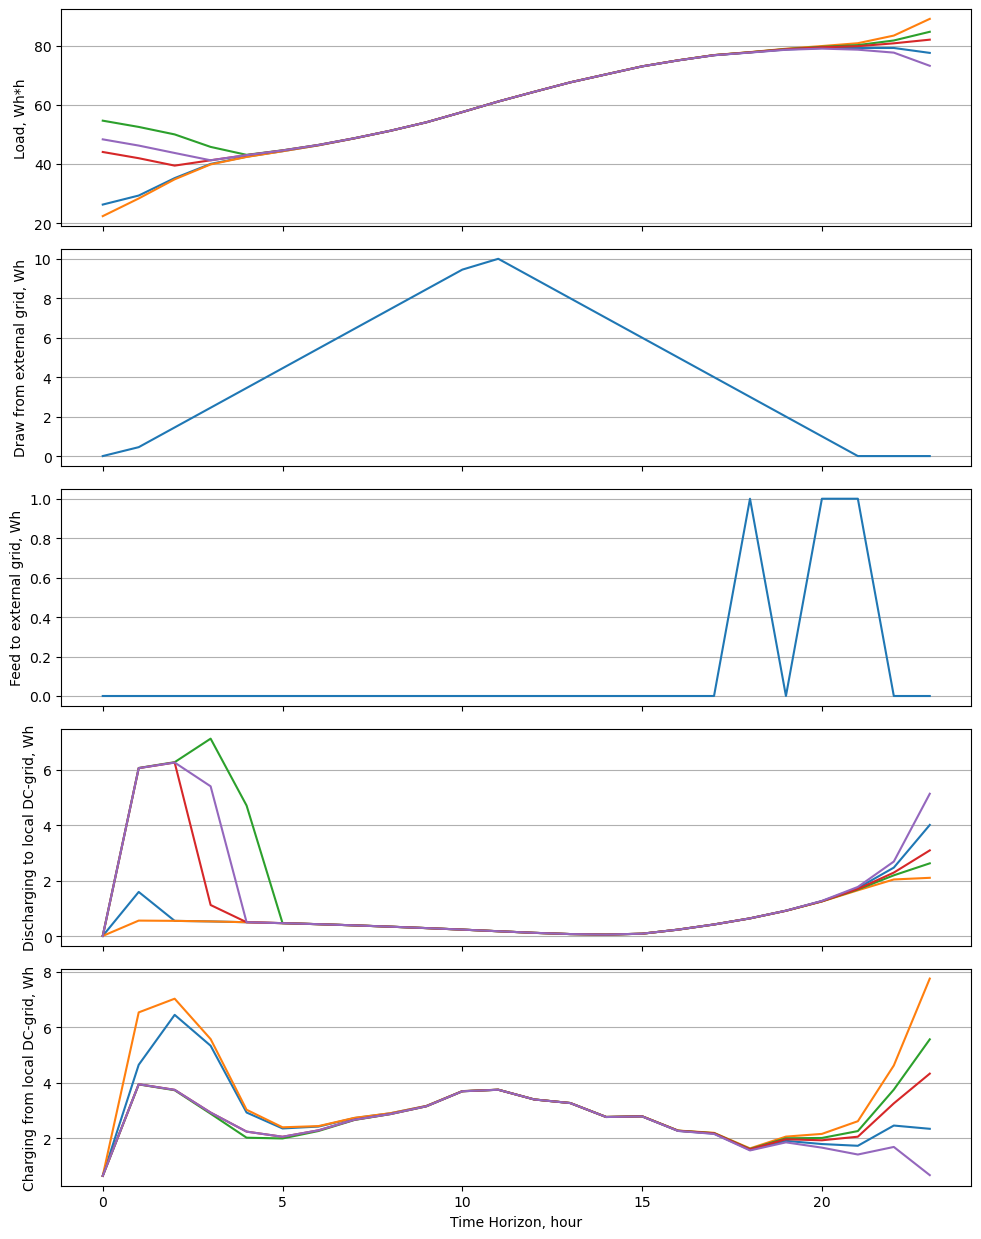

In [86]:
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(10, 5*2.5), sharex=True)
for m in range(M):
    for n in range(N):
        #axes[0].plot(np.full(H,L_target[n]))
        axes[0].plot(L_history[m][n], label =f'agent {n}')
        axes[0].grid(axis='y')
        #axes[0].legend()
        axes[0].set_ylabel("Load, Wh*h")
    

    axes[1].plot(d_history[m])
    axes[1].grid(axis='y')
    axes[1].set_ylabel("Draw from external grid, Wh")
    

    axes[2].plot(f_history[m])
    axes[2].grid(axis='y')
    axes[2].set_ylabel("Feed to external grid, Wh")
        
    for n in range(N):
        axes[3].plot(r_history[m][n])
        axes[3].grid(axis='y')
        axes[3].set_ylabel("Discharging to local DC-grid, Wh")
        
    for n in range(N):
        axes[4].plot(l_history[m][n])
        axes[4].grid(axis='y')
        axes[4].set_ylabel("Charging from local DC-grid, Wh")
    

axes[-1].set_xlabel('Time Horizon, hour')
plt.tight_layout()
plt.savefig("Decentralised multilayer framework", dpi=300)
plt.show()

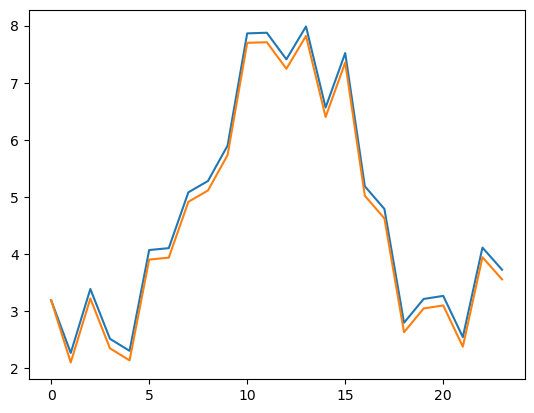

In [88]:
for m in range(M):
    plt.plot(-d_history[m]+f_history[m]+np.sum(l_history[m],axis=0)-np.sum(r_history[m],axis=0))
    plt.plot(q[m])

In [90]:
for m in range(M):
    total_cost = 0
    total_cost += np.sum(c * d_history[m] / q[m] - p * f_history[m] / q[m]) + (L_target[m] - L_history[m][:,-1]).T@(L_target[m] - L_history[m][:,-1])

    print(total_cost)

3.721571298093294


In [92]:
for m in range(M):
    for n in range(N):
        print(f"Error between target and real load of {1+n} agent is {100 * (L_target[m][n] - L_history[m][n][-1])/L_target[m][n]:.2f}%")

Error between target and real load of 1 agent is -0.14%
Error between target and real load of 2 agent is -0.12%
Error between target and real load of 3 agent is -0.12%
Error between target and real load of 4 agent is -0.13%
Error between target and real load of 5 agent is -0.14%


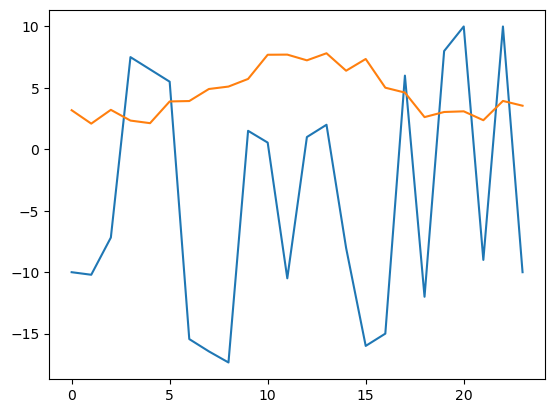

In [64]:
for m in range(M):
    plt.plot(-d_history[m]+f_history[m]+np.sum(l_history[m],axis=0)-np.sum(r_history[m],axis=0))
    plt.plot(q[m])